## Kết nối đến thư mục Google Drive

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import os
project_path = '/content/drive/MyDrive/EdgeAIK03/M13K03_EdgeAI_MachineLearning_2'
os.chdir(project_path)

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/EdgeAIK03/M13K03_EdgeAI_MachineLearning_2


### Đọc Data và chia nhóm

#### Load data từ File đã trích xuất đặc trưng từ trước

In [77]:
import glob
import os
import numpy as np
import json
from PIL import Image

root_path = r'CarDetection'

anno_name = r'bounding_boxes.labels'

data_lst = []
bbox_lst = []

cls_lst = ['car', 'truck']

for dir_name in ['training', 'testing']:
  with open(os.path.join(root_path, dir_name, anno_name), 'r') as labels_file:
    labels_json = json.load(labels_file).get('boundingBoxes')
  for img_name, bboxes in labels_json.items():
    img_path = os.path.join(root_path, dir_name, img_name)
    if os.path.exists(img_path):
      data_lst.append(Image.open(img_path).convert("RGB"))
      bbox_lst.append([[[box.get('x'), box.get('y'), box.get('width'), box.get('height')], cls_lst.index(box.get('label'))] for box in bboxes])

print(f'Tổng số dữ liệu: {len(data_lst)}')
print(data_lst[0].size)
print(len(bbox_lst[0]), bbox_lst[0])

Tổng số dữ liệu: 127
(640, 480)
14 [[[2, 108, 24, 27], 0], [[582, 78, 58, 47], 0], [[346, 93, 86, 39], 0], [[462, 82, 84, 42], 0], [[186, 100, 84, 39], 0], [[580, 150, 60, 59], 0], [[2, 220, 68, 60], 0], [[254, 231, 64, 71], 0], [[570, 228, 68, 74], 0], [[482, 225, 86, 83], 0], [[214, 390, 172, 89], 0], [[176, 229, 61, 72], 0], [[277, 92, 78, 42], 0], [[323, 212, 73, 90], 0]]


#### Chia tập dữ liệu thành tập Train (70%), Valid (15%), Test (15%)

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(data_lst, bbox_lst, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5)

# Print status
print("X train shape: {} \t X val shape: {} \t X test shape: {}".format(len(X_train), len(X_val), len(X_test)))
print("y train shape: {} \t y val shape: {} \t y test shape: {}".format(len(y_train), len(y_val), len(y_test)))

X train shape: 88 	 X val shape: 19 	 X test shape: 20
y train shape: 88 	 y val shape: 19 	 y test shape: 20


#### Hàm chuyển bbox (x_min, y_min, w, h) thành (x_center, y_center)

In [78]:
import torch


# Hàm chuyển đổi bbox thành điểm trung tâm
def bbox_to_center(bbox):
  # bbox: [x_min, y_min, w, h]
  x_center = bbox[0] + bbox[2]/2
  y_center = bbox[1] + bbox[3]/2
  return int(x_center), int(y_center)


def bbox_to_segmentation(size_wh, bboxes, grid_size=12, num_classes=2):
  """
  Convert bounding box annotations to segmentation maps for training.
  """
  w, h = size_wh  # Kích thước ảnh
  seg_map = torch.zeros((num_classes + 1, grid_size, grid_size), dtype=torch.long)
  seg_map[0, :, :] = 1.0
  cell_h, cell_w = h / grid_size, w / grid_size
  for bbox, class_id in bboxes:  # bboxes: [(bbox, class_id), ...]
    x_center, y_center = bbox_to_center(bbox)
    grid_x, grid_y = int(x_center // cell_w), int(y_center // cell_h)
    # print(x_center, y_center, grid_y, grid_x, class_id, seg_map.shape)
    seg_map[class_id+1, grid_x, grid_y] = 1.0
    seg_map[0, grid_x, grid_y] = 0.0

  return seg_map

#### Hàm chuyển đổi seg_map thành center và hàm vẽ

In [121]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def export_center(predicted, image_wh):
  x, y = torch.where(predicted == 1)
  w, h = image_wh
  print(image.size)
  cell_h, cell_w = h / 12, w / 12

  center_lst = []

  for i in range(len(x)):
    center_x = int((x[i] + 0.5) * cell_w)
    center_y = int((y[i] + 0.5) * cell_h)
    center_lst.append([center_x, center_y])
  return center_lst

def draw_center(image, center_lst):
  image_draw = image.copy()
  draw = ImageDraw.Draw(image_draw)
  color = (0, 255, 0)
  radius = 5
  for center_x, center_y in center_lst:
    draw.ellipse((center_x - radius, center_y - radius, center_x + radius, center_y + radius), fill=color)
  return image_draw

7
tensor([[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])
(640, 480)


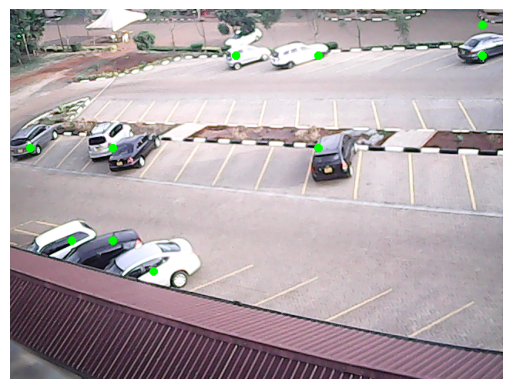

In [129]:
idx = random.randint(0, len(data_lst))

print(idx)

image = data_lst[idx]

y = bbox_to_segmentation(image.size, bbox_lst[idx], 12, num_classes=2).unsqueeze(0)
_, y_ = torch.max(y, 1)

print(y_)

plt.imshow(draw_center(image, export_center(y_[0], image.size)))
plt.axis('off')  # Tắt trục
plt.show()

#### Class Dataset

In [79]:
import numpy as np
import torch
from torch.utils.data import Dataset

class CarDetectionFOMODataset(Dataset):
  def __init__(self, images, bboxes, grid_size=12, num_classes=2, transform=None):
    self.images = images  # Dữ liệu đầu vào
    self.bboxes = bboxes  # phân loại tương ứng
    self.num_classes = num_classes
    self.transform = transform
    self.grid_size = grid_size

  def __len__(self):
    return len(self.images)  # Số lượng mẫu trong dataset

  def __getitem__(self, idx):
    # Trả về một cặp (dữ liệu, nhãn) cho chỉ số idx
    # waveform = np.load(self.data[idx])
    image = self.images[idx]
    bboxes = self.bboxes[idx]

    target = bbox_to_segmentation(image.size, bboxes, self.grid_size, num_classes=self.num_classes)

    if self.transform:
        image = self.transform(image)

    return torch.tensor(image, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

#### Thử khởi tạo dataset object

In [132]:
import torch
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),   # Chuyển ảnh PIL thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Nếu cần chuẩn hóa
])

train_dataset = CarDetectionFOMODataset(X_train, y_train, grid_size=12, transform=transform)
val_dataset = CarDetectionFOMODataset(X_val, y_val, grid_size=12, transform=transform)
test_dataset = CarDetectionFOMODataset(X_test, y_test, grid_size=12, transform=transform)


In [81]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
print(len(train_loader))
for images, targets in train_loader:
  print(images.shape, targets.shape)
  print(targets)

  break

127
torch.Size([1, 3, 96, 96]) torch.Size([1, 3, 12, 12])
tensor([[[[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
          [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.],
          [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
          [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
          [1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.]],

         [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0

<ipython-input-79-9c9b2557054a>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


### Tạo Model

In [82]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Cấu hình Model
file pretrained: https://github.com/d-li14/mobilenetv2.pytorch

In [83]:
import torch.nn as nn
import torch.nn.functional as F
import os
from models.imagenet import mobilenetv2


class FOMOWithMobileNetV2(nn.Module):
    def __init__(self, input_shape=(1, 96, 96), alpha=0.35, num_classes=2, pretrain_path=''):
        super(FOMOWithMobileNetV2, self).__init__()
        # Load MobileNetV2 backbone
        backbone = mobilenetv2(width_mult=alpha)
        if os.path.exists(pretrain_path):
          backbone.load_state_dict(torch.load(pretrain_path, map_location=torch.device('cpu')), strict=False)

        # Truncate MobileNetV2 to output feature maps at stride 8
        self.feature_extractor = nn.Sequential(
            *list(backbone.features)[:5]  # Block up to 'block_6_expand_relu'
        )

        # Head layers for constrained object detection
        self.head = nn.Conv2d(16, 32, kernel_size=1, stride=1)
        self.logits = nn.Conv2d(32, num_classes+1, kernel_size=1, stride=1)  # num_classes + 1 for background

    def forward(self, x):
        # Extract features using backbone
        x = self.feature_extractor(x)

        # Apply head layers
        x = F.relu(self.head(x))
        x = self.logits(x)  # Logits output
        return x

#### Hiển thị model

In [130]:
from torchsummary import summary


model = FOMOWithMobileNetV2(num_classes=2, pretrain_path='CarDetection/mobilenetv2_0.35-pretrained.pth')
# model = FOMOModel(num_classes=2)
model.to(device)
# Hiển thị cấu trúc của mô hình
summary(model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             432
       BatchNorm2d-2           [-1, 16, 48, 48]              32
             ReLU6-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 16, 48, 48]             144
       BatchNorm2d-5           [-1, 16, 48, 48]              32
             ReLU6-6           [-1, 16, 48, 48]               0
            Conv2d-7            [-1, 8, 48, 48]             128
       BatchNorm2d-8            [-1, 8, 48, 48]              16
  InvertedResidual-9            [-1, 8, 48, 48]               0
           Conv2d-10           [-1, 48, 48, 48]             384
      BatchNorm2d-11           [-1, 48, 48, 48]              96
            ReLU6-12           [-1, 48, 48, 48]               0
           Conv2d-13           [-1, 48, 24, 24]             432
      BatchNorm2d-14           [-1, 48,

<ipython-input-83-a49d0d6893a3>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone.load_state_dict(torch.load(pretrain_path, map_location=torch.device('cpu')), stric

### Tạo Loss Function, Optimizer, Training

#### Thiết lập thông số Train

In [88]:
learning_rate = 0.001  # Tốc độ học
epochs = 500  # Số chu kỳ huấn luyện
batch_size = 32  # Số dữ liệu cho 1 batch

#### Khởi tạo

In [133]:
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

class_weights = torch.tensor([100., 100., 100.])
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

3 88


#### Huấn luyện

In [134]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_model_path = 'CarDetection/best_model.pth'

# Biến kiểm soát early stopping
best_val_loss = float('inf')
best_val_epoch = 0
epochs_no_improve = 0
early_stop_patience = 50  # Số epoch không cải thiện trước khi dừng sớm

for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0
  for images, targets in train_loader:
    images, targets = images.to(device), targets.to(device)
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)

    # Compute loss
    loss = criterion(outputs, targets)
    running_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    _, targeted = torch.max(targets, 1)
    total_train += targets.size(0)
    correct_train += (predicted == targeted).sum().item() / targeted[0].numel()

    # Backward pass
    loss.backward()
    optimizer.step()

  # Tính train loss và accuracy
  train_loss = running_loss / len(train_loader)
  train_accuracy = 100 * correct_train / total_train
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # Đánh giá trên tập Val
  model.eval()  # Chuyển mô hình sang chế độ đánh giá
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for images, targets in train_loader:
      images, targets = images.to(device), targets.to(device)

      outputs = model(images)
      loss = criterion(outputs, targets)
      val_loss += loss.item()

      # Tính accuracy cho validation
      _, predicted = torch.max(outputs, 1)
      _, targeted = torch.max(targets, 1)
      total_val += targets.size(0)
      correct_val += (predicted == targeted).sum().item() / targeted[0].numel()
  # Tính validation loss và accuracy
  val_loss /= len(val_loader)
  val_accuracy = 100 * correct_val / total_val
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

  # Kiểm tra và lưu mô hình tốt nhất
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_val_epoch = epoch
    torch.save(model.state_dict(), best_model_path)  # Lưu mô hình tốt nhất
    print("Validation loss tốt nhất, lưu model.")
    epochs_no_improve = 0  # Reset số epoch không cải thiện
  else:
    epochs_no_improve += 1
    # print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")

  # Dừng sớm nếu không có cải thiện trong `early_stop_patience` epoch
  if epochs_no_improve >= early_stop_patience:
    print("Early stopping: Validation loss không thay đổi thêm.")
    break

# Tải mô hình tốt nhất sau khi huấn luyện
print(f'Kết thúc huấn luyện. Load weights tốt nhất ở chu kỳ {best_val_epoch}')
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Chuyển mô hình sang chế độ đánh giá

<ipython-input-79-9c9b2557054a>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


Epoch 1/500, Train Loss: 108.6131, Train Accuracy: 40.82%, Validation Loss: 305.7296, Validation Accuracy: 55.83%
Validation loss tốt nhất, lưu model.
Epoch 2/500, Train Loss: 102.3587, Train Accuracy: 53.21%, Validation Loss: 292.6376, Validation Accuracy: 68.42%
Validation loss tốt nhất, lưu model.
Epoch 3/500, Train Loss: 96.3769, Train Accuracy: 67.73%, Validation Loss: 279.3147, Validation Accuracy: 79.36%
Validation loss tốt nhất, lưu model.
Epoch 4/500, Train Loss: 90.7599, Train Accuracy: 78.83%, Validation Loss: 264.7029, Validation Accuracy: 84.99%
Validation loss tốt nhất, lưu model.
Epoch 5/500, Train Loss: 85.3860, Train Accuracy: 84.23%, Validation Loss: 249.1190, Validation Accuracy: 87.24%
Validation loss tốt nhất, lưu model.
Epoch 6/500, Train Loss: 80.1661, Train Accuracy: 87.26%, Validation Loss: 233.0634, Validation Accuracy: 88.03%
Validation loss tốt nhất, lưu model.
Epoch 7/500, Train Loss: 75.2708, Train Accuracy: 89.08%, Validation Loss: 217.0984, Validation Ac

#### Vẽ đồ thị quá trình huấn luyện

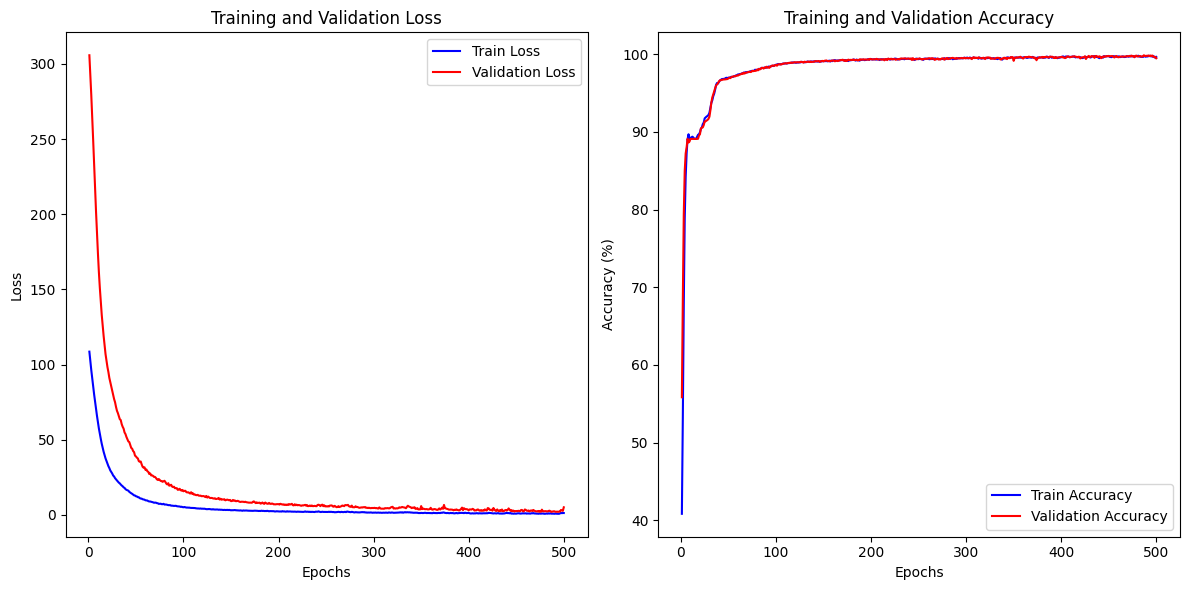

In [135]:
import matplotlib.pyplot as plt

# Vẽ đồ thị Loss và Accuracy
# Vẽ đồ thị Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Vẽ đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


#### Đánh giá mô hình

In [138]:
# Đánh giá trên tập kiểm tra (test)
all_lbs = []
all_predictions = []
with torch.no_grad():
  model.eval()
  for images, targets in test_loader:
    images, targets = images.to(device), targets.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    _, targeted = torch.max(targets, 1)

    all_lbs.extend(targeted.cpu().flatten().numpy())
    all_predictions.extend(predicted.cpu().flatten().numpy())

<ipython-input-79-9c9b2557054a>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


<Figure size 800x800 with 0 Axes>

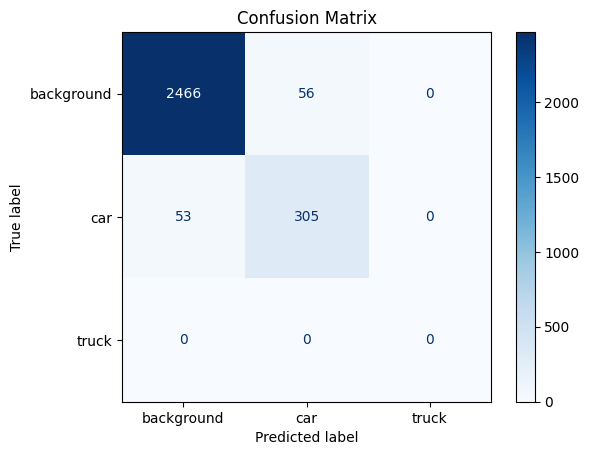

Precision: 0.96
Recall: 0.96
F1 Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2522
           1       0.84      0.85      0.85       358

    accuracy                           0.96      2880
   macro avg       0.91      0.91      0.91      2880
weighted avg       0.96      0.96      0.96      2880



In [144]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính ma trận nhầm lẫn
cm = confusion_matrix(all_lbs, all_predictions, labels=[0, 1, 2])

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['background', 'car', 'truck'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(all_lbs, all_predictions, average='weighted')
recall = recall_score(all_lbs, all_predictions, average='weighted')
f1 = f1_score(all_lbs, all_predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# In báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(all_lbs, all_predictions))


#### Chạy thử model

torch.Size([1, 3, 96, 96]) torch.Size([1, 3, 12, 12])
y_target: tensor([[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]]]) | y_predict: tensor([[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 

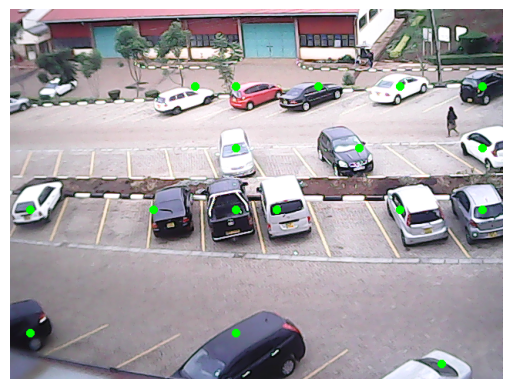

In [150]:
import torch
import random
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),   # Chuyển ảnh PIL thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Nếu cần chuẩn hóa
])

idx = random.randint(0, len(X_test))
image = X_test[idx]

model.eval()
x = transform(image).unsqueeze(0).to(device)
y = bbox_to_segmentation(image.size, y_test[idx], 12, num_classes=2).unsqueeze(0).to(device)
_, y__ = torch.max(y, 1)

print(x.shape, y.shape)

with torch.no_grad():
  output = model(x)
  _, predicted = torch.max(output, 1)
#   _, predicted = torch.max(output, 1)  # Lấy nhãn dự đoán
print(f'y_target: {y__} | y_predict: {predicted}')

plt.imshow(draw_center(image, export_center(predicted[0], image.size)))
plt.axis('off')  # Tắt trục
plt.show()

#### Chuyển đổi sang OnnxRuntime

In [151]:
!pip install onnx

In [154]:
import torch

# Đặt mô hình ở chế độ đánh giá
model.eval()

# Dummy input (kích thước phải giống với kích thước đầu vào của mô hình)
# Ví dụ: Input [batch_size=1, channels=3, height=224, width=224]
dummy_input = torch.randn(1, 3, 96, 96).to(device)

# Đường dẫn lưu mô hình ONNX
onnx_file_path = "CarDetection/best_model.onnx"

# Xuất mô hình sang định dạng ONNX
torch.onnx.export(
    model,                        # Mô hình PyTorch
    dummy_input,                  # Dummy input
    onnx_file_path,               # Đường dẫn lưu file .onnx
    export_params=True,           # Lưu tất cả tham số (weights) vào ONNX
    opset_version=12,             # Phiên bản ONNX (tùy chỉnh, thường dùng 11 hoặc 12)
    do_constant_folding=True,     # Tối ưu hóa các hằng số trong mô hình
    input_names=["input"],        # Tên đầu vào (có thể đặt tùy ý)
    output_names=["output"],      # Tên đầu ra (có thể đặt tùy ý)
    dynamic_axes={                # Định nghĩa trục động (batch size)
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

print(f"Model has been converted to ONNX and saved at {onnx_file_path}")


Model has been converted to ONNX and saved at CarDetection/best_model.onnx
